## Initial Steps

In [46]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch


- Create data frame

In [36]:
FILENAME = "Question 2 Student DATA.csv"

df = pd.read_csv(FILENAME)

df.head()

,STUDENT ID,Age,Gender,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,married,salary,Transportation to the university,...,Attendance to the seminars/conferences,Impact of your projects/activities,Attendance to classes,Preparation for midterm exams 1,Preparation for midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success,CGPA last sem,expected CGPA
0,STUDENT1,22.0,M,other,3,1,2,no,150.0,1,...,1,1,1,1.0,1,3,2,1,1,1
1,STUDENT2,22.0,M,other,3,1,2,no,150.0,1,...,1,1,1,1.0,1,3,2,3,2,3
2,STUDENT3,22.0,M,state,3,2,2,no,240.0,4,...,1,1,1,1.0,1,2,2,1,2,2
3,STUDENT4,18.0,F,private,3,1,2,yes,245.0,1,...,1,1,1,1.0,2,3,2,2,3,2
4,STUDENT5,23.0,M,private,3,2,2,yes,300.0,1,...,1,1,1,2.0,1,2,2,2,2,2


## **Problem Statement**
**"Cluster students based on their study habits and academic performance to identify distinct groups, and compare the results of k-means and hierarchical clustering."**

#### **Key Features** (Simple, Interpretable, and Numeric/Ordinal):
1. **Weekly study hours** (Attribute 18: 1–5, ordinal).  
2. **Attendance to classes** (Attribute 23: 1–3, ordinal; reverse-coded for clarity, e.g., 1=never → 3=always).  
3. **Taking notes** (Attribute 26: 1–3, ordinal).  
4. **Cumulative GPA** (Attribute 29: 1–5, ordinal).  



##### 1. Select Attributes & Load Data

In [37]:
selected_columns = [
    "Weekly study hours",
    "Attendance to classes",
    "Taking notes in classes",
    "CGPA last sem"
]

df = df[selected_columns]
df.head()

,Weekly study hours,Attendance to classes,Taking notes in classes,CGPA last sem
0,3,1,3,1
1,2,1,3,2
2,2,1,2,2
3,3,1,3,3
4,2,1,2,2


##### 2.  Normalize data

In [38]:
df["Attendance to classes"] = df["Attendance to classes"].apply(lambda x: 4 - x)

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,Weekly study hours,Attendance to classes,Taking notes in classes,CGPA last sem
0,3,3,3,1
1,2,3,3,2
2,2,3,2,2
3,3,3,3,3
4,2,3,2,2


In [45]:
print("\nCorrelation matrix after scaling:")
print(df_normalized.corr())


Correlation matrix after scaling:
                         Weekly study hours  Attendance to classes  \
Weekly study hours                 1.000000               0.123396   
Attendance to classes              0.123396               1.000000   
Taking notes in classes            0.163465               0.145107   
CGPA last sem                      0.008145               0.178305   

                         Taking notes in classes  CGPA last sem  
Weekly study hours                      0.163465       0.008145  
Attendance to classes                   0.145107       0.178305  
Taking notes in classes                 1.000000       0.143541  
CGPA last sem                           0.143541       1.000000  


`The correlations are all quite low (mostly below 0.2), which tells us that these features are largely independent.`

### Elbow Method to find K

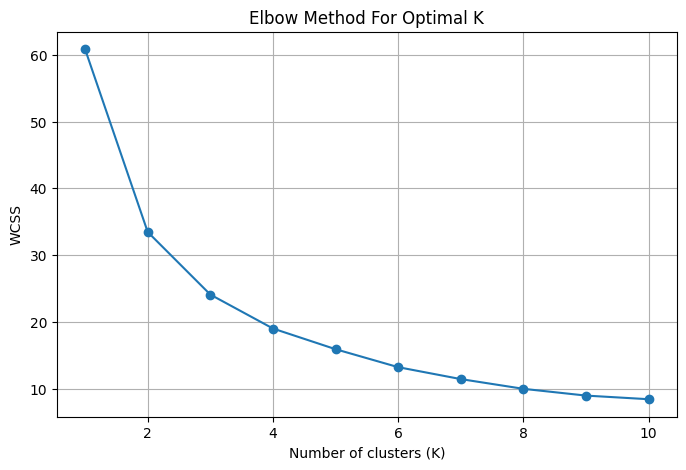

In [40]:
wcss = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(df_normalized)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


K-Means Run 1: Iterations = 4, WCSS = 19.11, BCSS = 41.74, Time = 0.0036 seconds
K-Means Run 2: Iterations = 6, WCSS = 19.48, BCSS = 41.37, Time = 0.0027 seconds
K-Means Run 3: Iterations = 3, WCSS = 22.11, BCSS = 38.74, Time = 0.0018 seconds


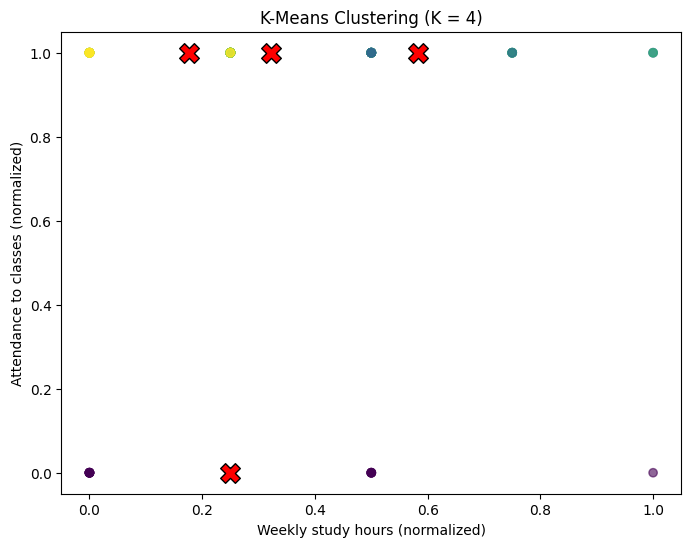

In [41]:
best_k = 4

def compute_tss(X):
    return np.sum((X - np.mean(X, axis=0)) ** 2)

X = df_normalized.values
tss = compute_tss(X)

n_runs = 3
kmeans_results = []
for run in range(n_runs):
    start = time.time()
    km = KMeans(n_clusters=best_k, init='random', n_init=1, random_state=None)
    km.fit(X)
    end = time.time()
    
    iterations = km.n_iter_
    wcss_run = km.inertia_
    bcss_run = tss - wcss_run
    
    kmeans_results.append({
        "run": run + 1,
        "iterations": iterations,
        "WCSS": wcss_run,
        "BCSS": bcss_run,
        "time": end - start
    })
    print(f"K-Means Run {run+1}: Iterations = {iterations}, WCSS = {wcss_run:.2f}, "
          f"BCSS = {bcss_run:.2f}, Time = {end - start:.4f} seconds")

# (For visualization, we plot the first two features.)
labels_km = km.labels_
plt.figure(figsize=(8, 6))
plt.scatter(df_normalized.iloc[:, 0], df_normalized.iloc[:, 1], c=labels_km, cmap='viridis', alpha=0.6)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=200, c='red', marker='X', edgecolors='black')
plt.title(f"K-Means Clustering (K = {best_k})")
plt.xlabel("Weekly study hours (normalized)")
plt.ylabel("Attendance to classes (normalized)")
plt.show()

#### Hierarchical clustering

Hierarchical (single) K=2: SSE = 33.46, Time = 0.0027 seconds
Hierarchical (single) K=3: SSE = 32.03, Time = 0.0022 seconds
Hierarchical (single) K=4: SSE = 31.35, Time = 0.0016 seconds


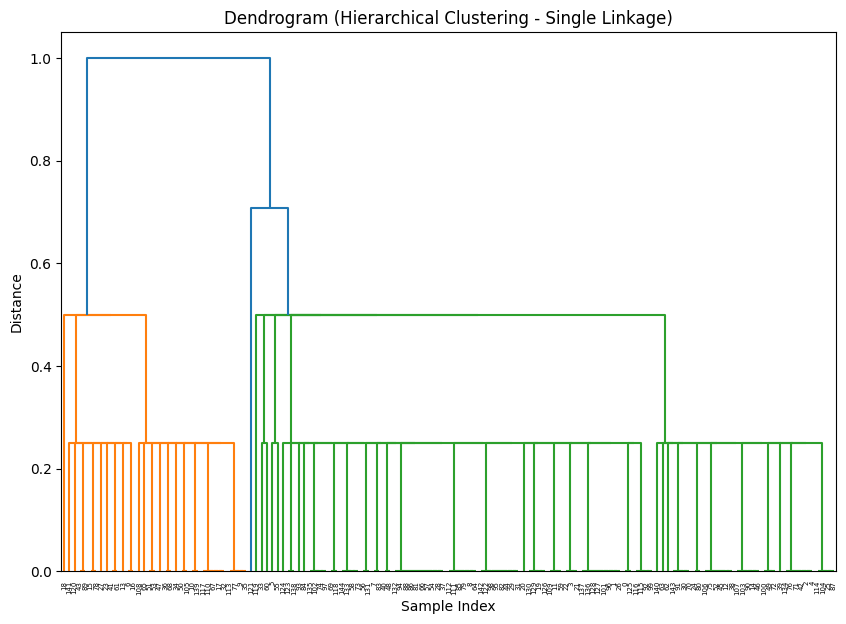

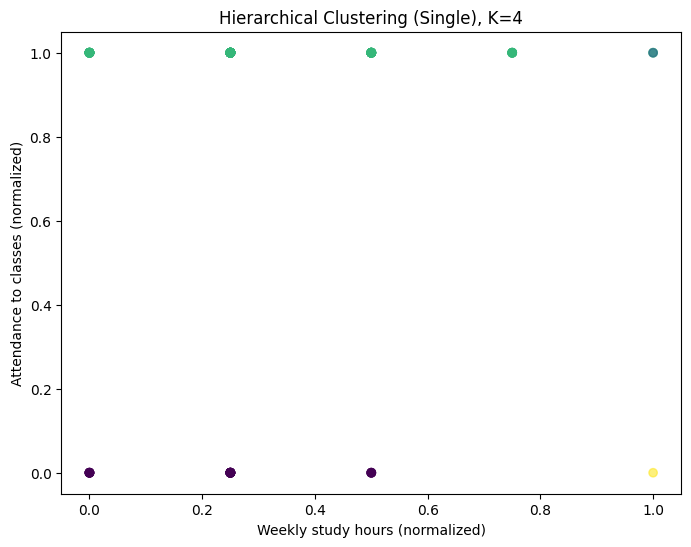

Hierarchical (complete) K=2: SSE = 54.94, Time = 0.0019 seconds
Hierarchical (complete) K=3: SSE = 28.21, Time = 0.0016 seconds
Hierarchical (complete) K=4: SSE = 26.78, Time = 0.0011 seconds


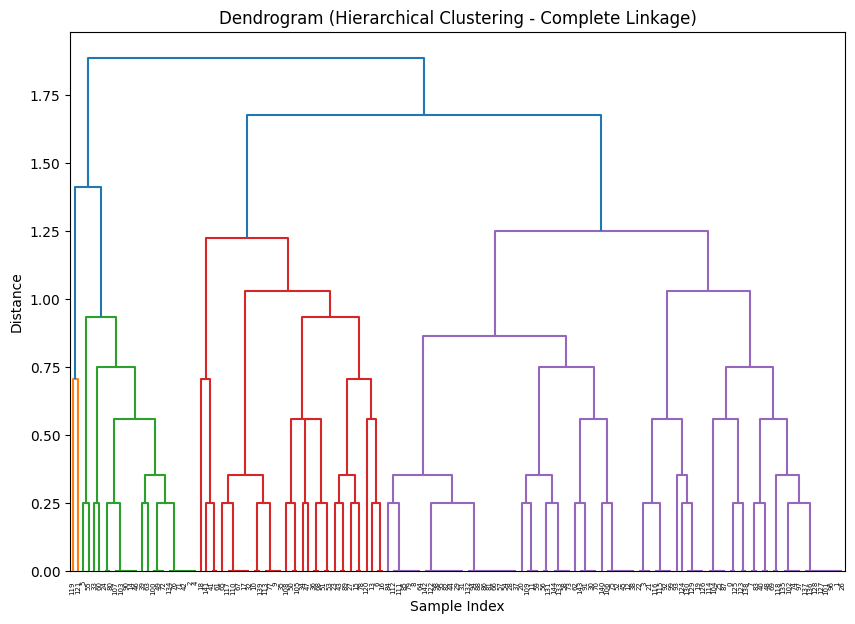

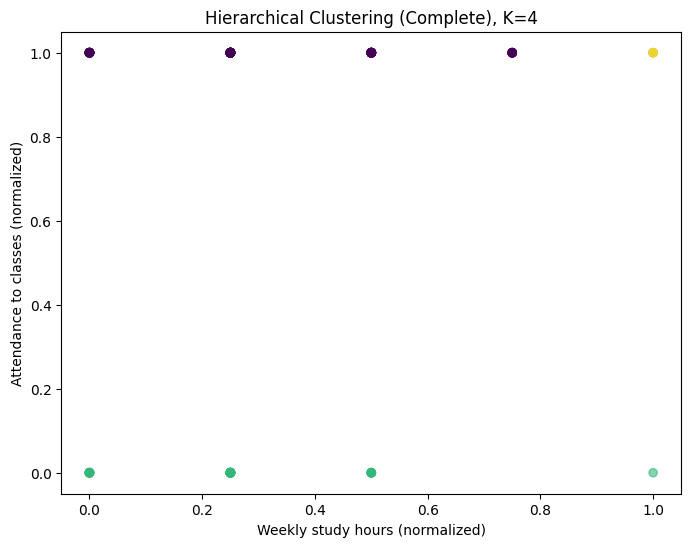

Hierarchical (average) K=2: SSE = 33.46, Time = 0.0025 seconds
Hierarchical (average) K=3: SSE = 31.70, Time = 0.0033 seconds
Hierarchical (average) K=4: SSE = 30.00, Time = 0.0014 seconds


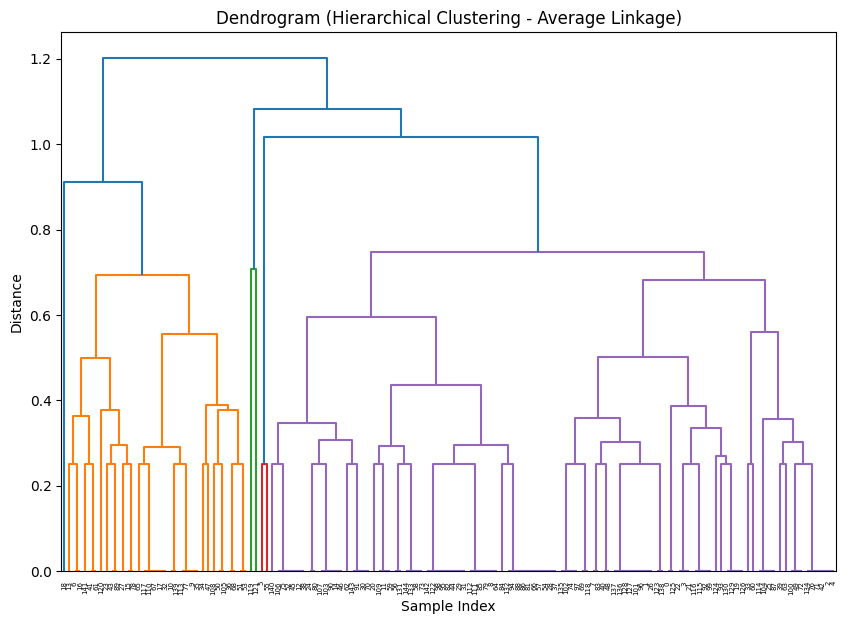

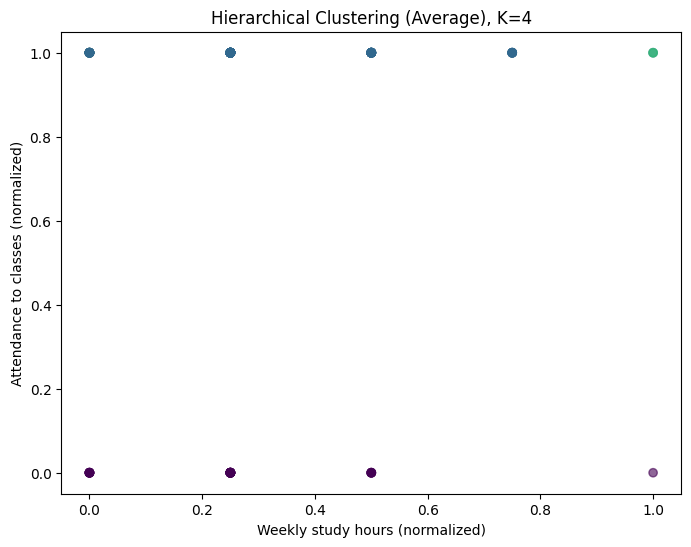

In [49]:
def compute_sse(X, labels):
    sse = 0.0
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        centroid = np.mean(cluster_points, axis=0)
        sse += np.sum((cluster_points - centroid) ** 2)
    return sse

linkage_methods = ['single', 'complete', 'average']
hierarchical_results = {}

for method in linkage_methods:
    hierarchical_results[method] = {}
    for k in range(2, best_k + 1):
        start = time.time()
        hc = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels_hc = hc.fit_predict(X)
        end = time.time()
        
        sse_hc = compute_sse(X, labels_hc)
        hierarchical_results[method][k] = {"labels": labels_hc, "SSE": sse_hc, "time": end - start}
        print(f"Hierarchical ({method}) K={k}: SSE = {sse_hc:.2f}, Time = {end - start:.4f} seconds")
    
    # Plot dendrogram for the current linkage method.
    plt.figure(figsize=(10, 7))
    Z = sch.linkage(X, method=method)
    sch.dendrogram(Z)
    plt.title(f"Dendrogram (Hierarchical Clustering - {method.capitalize()} Linkage)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()
    
    # Plot scatter plot for best_k using this linkage method.
    best_labels = hierarchical_results[method][best_k]["labels"]
    plt.figure(figsize=(8, 6))
    plt.scatter(df_normalized.iloc[:, 0], df_normalized.iloc[:, 1], c=best_labels, cmap='viridis', alpha=0.6)
    plt.title(f"Hierarchical Clustering ({method.capitalize()}), K={best_k}")
    plt.xlabel("Weekly study hours (normalized)")
    plt.ylabel("Attendance to classes (normalized)")
    plt.show()


### Comparison

In [50]:
print("\n--- K-Means Results ---")
for res in kmeans_results:
    print(res)

print("\n--- Hierarchical Clustering Results ---")
for method in hierarchical_results:
    for k in hierarchical_results[method]:
        res = hierarchical_results[method][k]
        print(f"Method: {method.capitalize()}, K={k}, SSE: {res['SSE']:.2f}, Time: {res['time']:.4f} sec")


--- K-Means Results ---
{'run': 1, 'iterations': 4, 'WCSS': 19.10848214285714, 'BCSS': np.float64(41.74324199507389), 'time': 0.003591775894165039}
{'run': 2, 'iterations': 6, 'WCSS': 19.483741729968145, 'BCSS': np.float64(41.367982407962884), 'time': 0.002743244171142578}
{'run': 3, 'iterations': 3, 'WCSS': 22.11427396616541, 'BCSS': np.float64(38.737450171765616), 'time': 0.001844167709350586}

--- Hierarchical Clustering Results ---
Method: Single, K=2, SSE: 33.46, Time: 0.0027 sec
Method: Single, K=3, SSE: 32.03, Time: 0.0022 sec
Method: Single, K=4, SSE: 31.35, Time: 0.0016 sec
Method: Complete, K=2, SSE: 54.94, Time: 0.0019 sec
Method: Complete, K=3, SSE: 28.21, Time: 0.0016 sec
Method: Complete, K=4, SSE: 26.78, Time: 0.0011 sec
Method: Average, K=2, SSE: 33.46, Time: 0.0025 sec
Method: Average, K=3, SSE: 31.70, Time: 0.0033 sec
Method: Average, K=4, SSE: 30.00, Time: 0.0014 sec
